# PART 1 - OpenCV

In [41]:
import os
import cv2
import zipfile

import numpy as np
import glob
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid

In [42]:
# Download the dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

# Unzip the dataset using zipfile module
with zipfile.ZipFile('brain-mri-images-for-brain-tumor-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./input/')

/usr/bin/bash: /home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /usr/bin/bash)
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [43]:
import os
import shutil
from pathlib import Path
import random

# Define the source and destination paths
source_path = Path('./input/brain_tumor_dataset')
destination_path = Path('processed')

# Delete the directories first if exist and then create them
shutil.rmtree(destination_path, ignore_errors=True)

# Create the processed directory and subdirectories
(destination_path / 'train' / 'yes').mkdir(parents=True, exist_ok=True)
(destination_path / 'train' / 'no').mkdir(parents=True, exist_ok=True)
(destination_path / 'valid' / 'yes').mkdir(parents=True, exist_ok=True)
(destination_path / 'valid' / 'no').mkdir(parents=True, exist_ok=True)
(destination_path / 'test' / 'yes').mkdir(parents=True, exist_ok=True)
(destination_path / 'test' / 'no').mkdir(parents=True, exist_ok=True)

# Ensure all images are 3 channel images
def ensure_images_is_rgb(file_path):
    image = Image.open(file_path)
    if image.mode != 'RGB':
        print(f"Converting {file_path} from {image.mode} to RGB")
        image = image.convert('RGB')
        image.save(file_path)

# Function to split and move files
def split_and_move_files(category):
    files = list((source_path / category).glob('*'))
    random.shuffle(files)
    
    train_split = int(0.8 * len(files))
    valid_split = int(0.1 * len(files))
    
    train_files = files[:train_split]
    valid_files = files[train_split:train_split + valid_split]
    test_files = files[train_split + valid_split:]
    
    for f in train_files:
        shutil.copy(str(f), str(destination_path / 'train' / category / f.name))
        ensure_images_is_rgb(str(destination_path / 'train' / category / f.name))
    for f in valid_files:
        shutil.copy(str(f), str(destination_path / 'valid' / category / f.name))
        ensure_images_is_rgb(str(destination_path / 'valid' / category / f.name))
    for f in test_files:
        shutil.copy(str(f), str(destination_path / 'test' / category / f.name))
        ensure_images_is_rgb(str(destination_path / 'test' / category / f.name))

# Split and copy files for 'yes' and 'no' categories
split_and_move_files('yes')
split_and_move_files('no')

print("Files split and moved successfully.")

Converting processed/train/yes/Y12.jpg from L to RGB
Converting processed/train/yes/Y52.jpg from L to RGB
Converting processed/train/yes/Y62.jpg from L to RGB
Converting processed/train/yes/Y31.jpg from L to RGB
Converting processed/train/yes/Y41.jpg from L to RGB
Converting processed/train/yes/Y10.jpg from L to RGB
Converting processed/train/yes/Y54.jpg from L to RGB
Converting processed/train/yes/Y101.jpg from L to RGB
Converting processed/train/yes/Y17.jpg from L to RGB
Converting processed/train/yes/Y24.jpg from L to RGB
Converting processed/train/yes/Y30.jpg from L to RGB
Converting processed/train/yes/Y70.jpg from L to RGB
Converting processed/train/yes/Y37.jpg from L to RGB
Converting processed/valid/yes/Y14.jpg from L to RGB
Converting processed/test/yes/Y92.png from L to RGB
Converting processed/test/yes/Y39.jpg from L to RGB
Converting processed/test/yes/Y38.jpg from L to RGB
Converting processed/train/no/48 no.jpeg from L to RGB
Converting processed/train/no/N15.jpg from L t

In [44]:
tumour_images=[]
for name in glob.glob('./input/brain_tumor_dataset/yes/*.jpg'): 
    image = cv2.imread(name)
    image = cv2.resize(image,(240,240))
    tumour_images.append(image)

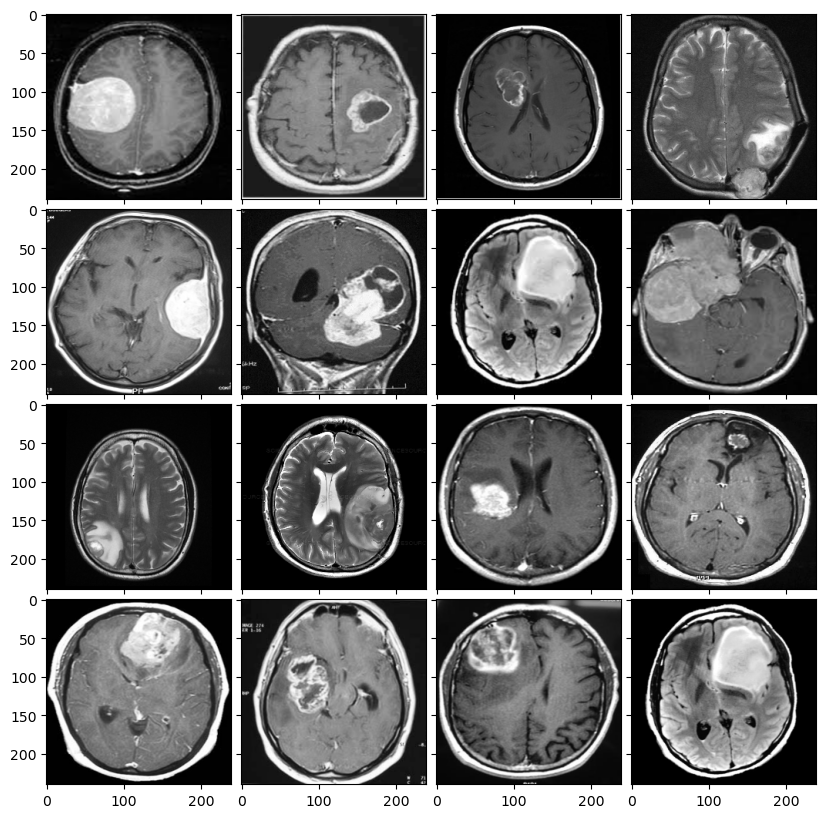

In [45]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4),  axes_pad=0.1,   )
for ax, im in zip(grid, tumour_images[0:16]):
    ax.imshow(im)
plt.show()

In [46]:
img_path = "./input/brain_tumor_dataset/yes/Y104.jpg"
image = cv2.imread(img_path)
print("width: {} pixels".format(image.shape[1]))
print("height: {} pixels".format(image.shape[0]))
print("channels: {}".format(image.shape[2]))
dim=(500,590)
image=cv2.resize(image, dim)

width: 700 pixels
height: 890 pixels
channels: 3


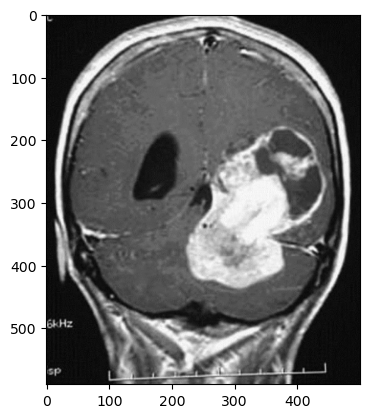

In [47]:
plt.imshow(image)

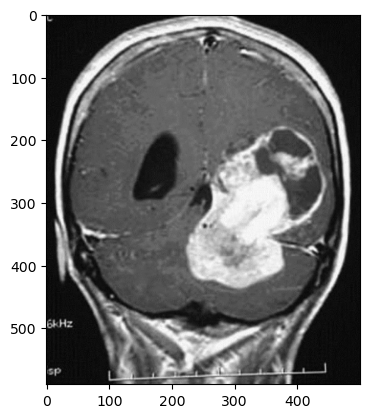

In [48]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, 0.7)
plt.imshow(image)


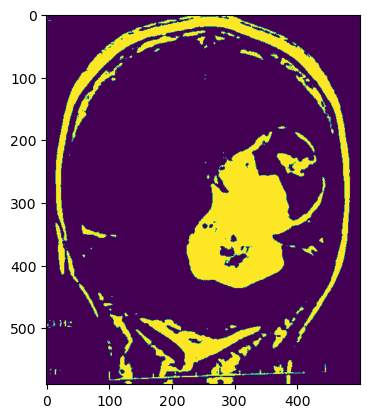

In [49]:
(T, thresh) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)


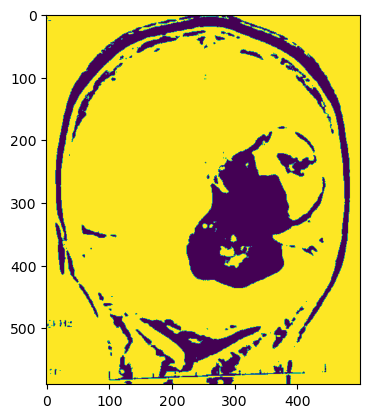

In [50]:
(T, threshInv) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY_INV)
plt.imshow(threshInv)


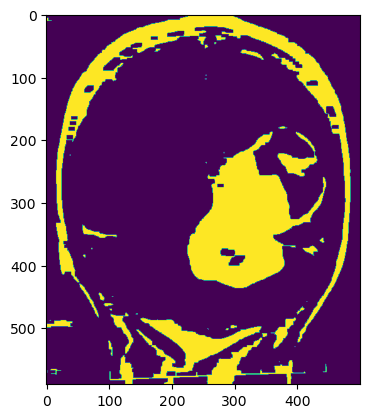

In [51]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 5))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed)

In [52]:
closed = cv2.erode(closed, None, iterations = 19)
closed = cv2.dilate(closed, None, iterations = 17)

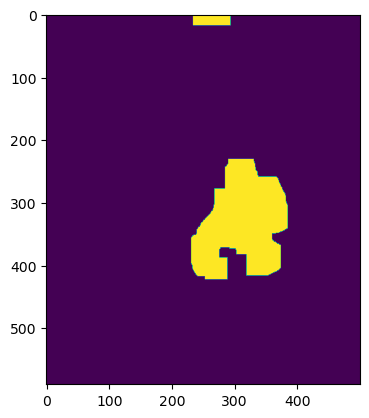

In [53]:
plt.imshow(closed)

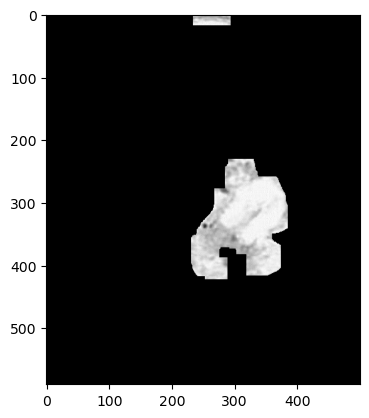

In [54]:
ret,mask = cv2.threshold(closed, 155, 255, cv2.THRESH_BINARY) 
#apply AND operation on image and mask generated by thrresholding
final = cv2.bitwise_and(image,image,mask = mask) 
plt.imshow(final)

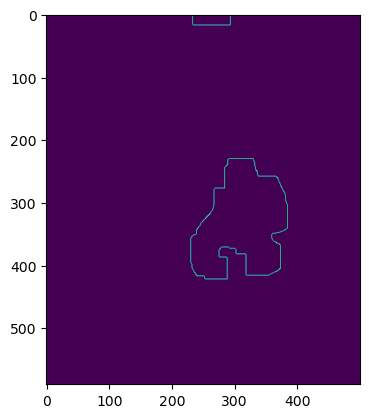

In [55]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    
    # return the edged image
    return edged

canny = auto_canny(closed)
plt.imshow(canny)

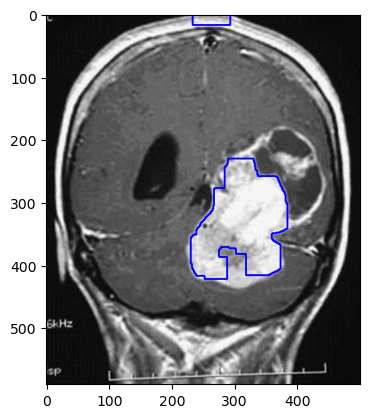

In [56]:
(cnts, _) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL,
cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, cnts, -1, (0, 0, 255), 2)
plt.imshow(image) 

# Part 2 - FastAI

In [57]:
import numpy as np 
import pandas as pd 
import os,gc,pathlib
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
import torchvision.models as models
from pathlib import Path

print(os.listdir("./input"))

['brain_tumor_dataset', 'models', 'no', 'yes']


In [58]:
import torch
import gc

def clean_up():
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    gc.collect()

In [59]:
DATA_DIR= Path('./processed/')

In [60]:
os.listdir(f'{DATA_DIR}')

['test', 'train', 'valid']

In [61]:
from fastai.vision.all import *

batch_tfms = [
    *aug_transforms(
        size=224, 
        mult=1.0,
        do_flip=True,
        flip_vert=False,
        max_rotate= 10.0,
        min_zoom= 1.0,
        max_zoom= 1.0,
        max_lighting= 0.2,
        max_warp= 0.2,
        p_affine= 0.75,
        p_lighting= 0.75,
        xtra_tfms= None,
        mode='bilinear',
        pad_mode='reflection',
        align_corners=True,
        batch=False,
        min_scale=1.1,
        ), 
    Normalize.from_stats(*imagenet_stats)]

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=batch_tfms
).dataloaders(DATA_DIR, bs=16)

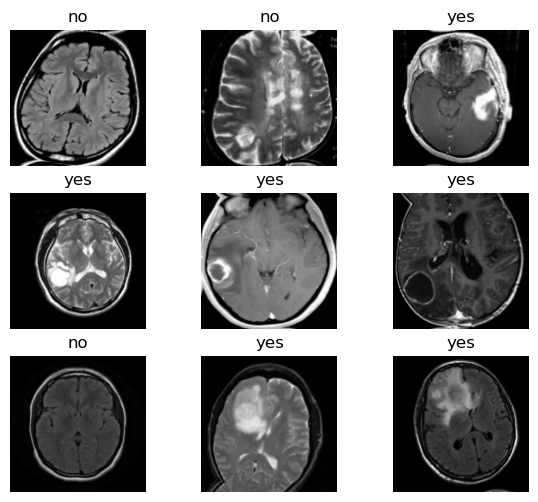

In [62]:
dls.show_batch(figsize=(7,6))

In [63]:
import timm
 
def get_learner(model_name='xresnet50', patience=3, bs=16):
    # Create the model based on the no of classes in the data coming from the dataloaders dls.c
    the_model = timm.create_model(model_name, pretrained=True, num_classes=dls.c)

    # Create the Learner
    learner = Learner(
        dls,
        the_model,
        metrics=accuracy,
        cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=patience)]
    )
    
    learner.dls.bs = bs
    
    learner.add_cb(SaveModelCallback(monitor='valid_loss', fname=f'{model_name}_best_model'))
    
    return learner


In [64]:
clean_up()

/home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_locati

Slide: 0.005248074419796467
Valley: 0.0003311311302240938
Minimum: 4.786300996784121e-05
Steep: 3.311311274956097e-06


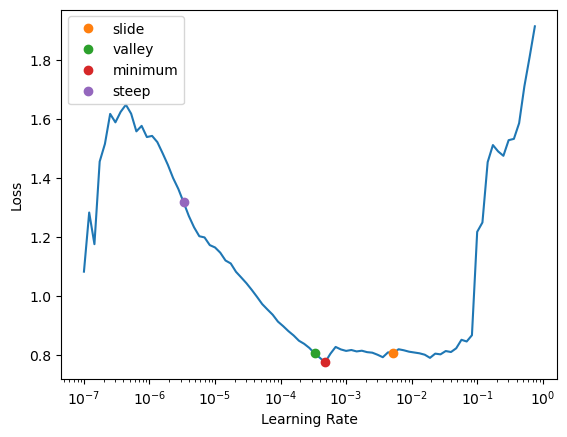

In [65]:
PERFORM_EXPORT = True
model_name='convnext_tiny'
learner = get_learner(model_name=model_name, patience=8)
lr_slide, lr_valley, lr_min, lr_steep = learner \
    .lr_find(suggest_funcs=(slide, valley, minimum, steep))

# Display all the learning rates
print(f"Slide: {lr_slide}")
print(f"Valley: {lr_valley}")
print(f"Minimum: {lr_min}")
print(f"Steep: {lr_steep}")


epoch,train_loss,valid_loss,accuracy,time
0,0.720544,0.445377,0.708333,00:02
1,0.561350,0.370605,0.791667,00:02
2,0.499190,0.209276,0.958333,00:02
3,0.428358,0.100423,1.000000,00:02
4,0.404218,0.206179,0.916667,00:02
5,0.395696,0.348196,0.916667,00:02
6,0.353365,0.081350,0.958333,00:02
7,0.312988,0.297626,0.833333,00:02
8,0.297450,0.120467,1.000000,00:02
9,0.267438,0.109417,0.958333,00:02


Better model found at epoch 0 with valid_loss value: 0.44537684321403503.
Better model found at epoch 1 with valid_loss value: 0.3706052303314209.
Better model found at epoch 2 with valid_loss value: 0.2092759609222412.
Better model found at epoch 3 with valid_loss value: 0.10042253136634827.
Better model found at epoch 6 with valid_loss value: 0.081350177526474.
No improvement since epoch 6: early stopping


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

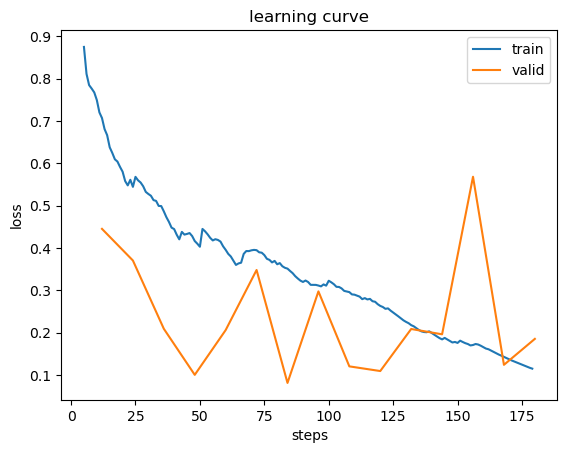

In [66]:

learner.freeze()
learner.fit_one_cycle(20, lr_valley)    

learner.recorder.plot_loss()

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

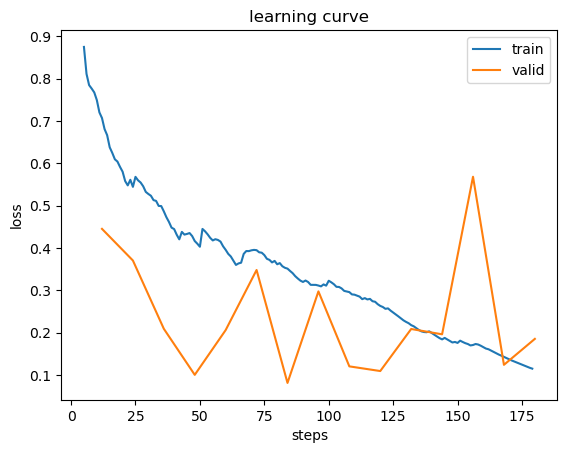

In [67]:
learner.recorder.plot_loss()

In [68]:
interp = ClassificationInterpretation.from_learner(learner)

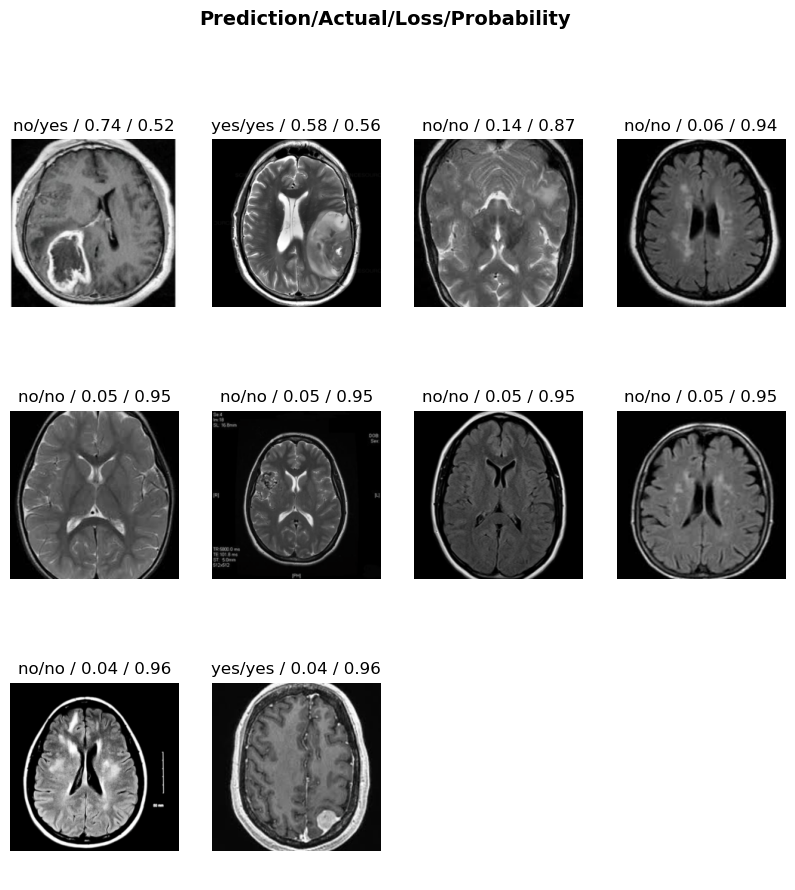

In [69]:
interp.plot_top_losses(10, figsize=(10,10))

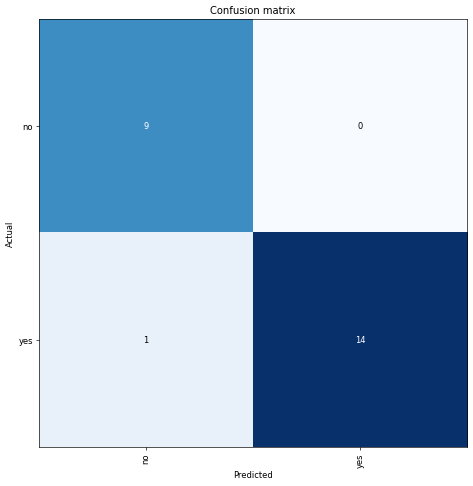

In [70]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [71]:
# Get the top losses
losses, idxs = interp.top_losses()

# Assuming the dataset has a method to retrieve the filenames
top_confused_files = [dls.valid_ds.items[i] for i in idxs]
print(top_confused_files)

[Path('processed/valid/yes/Y109.JPG'), Path('processed/valid/yes/Y108.jpg'), Path('processed/valid/no/N6.jpg'), Path('processed/valid/no/42 no.jpg'), Path('processed/valid/no/4 no.jpg'), Path('processed/valid/no/No14.jpg'), Path('processed/valid/no/no 99.jpg'), Path('processed/valid/no/27 no.jpg'), Path('processed/valid/no/no 9.png'), Path('processed/valid/yes/Y56.jpg'), Path('processed/valid/no/18 no.jpg'), Path('processed/valid/no/no 89.jpg'), Path('processed/valid/yes/Y33.jpg'), Path('processed/valid/yes/Y246.JPG'), Path('processed/valid/yes/Y42.jpg'), Path('processed/valid/yes/Y22.jpg'), Path('processed/valid/yes/Y65.JPG'), Path('processed/valid/yes/Y250.jpg'), Path('processed/valid/yes/Y34.jpg'), Path('processed/valid/yes/Y159.JPG'), Path('processed/valid/yes/Y51.jpg'), Path('processed/valid/yes/Y27.jpg'), Path('processed/valid/yes/Y19.JPG'), Path('processed/valid/yes/Y14.jpg')]


In [72]:
dls.vocab

['no', 'yes']

In [73]:

from fastai.vision.all import *

# Load the test set
test_files = get_image_files(DATA_DIR/'test')
test_dl = dls.test_dl(test_files)

# Get predictions on the test set 
learner.load(f'{model_name}_best_model')
preds, _ = learner.get_preds(dl=test_dl)

# Get the actual labels from the folder names and convert to tensor
test_labels = tensor([dls.vocab.o2i[parent_label(f)] for f in test_files])

# # Print shapes of preds and test_labels
# print(f"Shape of preds: {preds.shape}")
# print(f"Shape of test_labels: {test_labels.shape}")

# # Print length of preds.argmax(dim=1) and test_labels
# print(f"Length of preds.argmax(dim=1): {len(preds.argmax(dim=1))}")
# print(f"Length of test_labels: {len(test_labels)}")

# # Print data types of preds.argmax(dim=1) and test_labels
# print(f"Data type of preds.argmax(dim=1): {preds.argmax(dim=1).dtype}")
# print(f"Data type of test_labels: {test_labels.dtype}")

# # Print entire contents of preds.argmax(dim=1) and test_labels
# print(f"Contents of preds.argmax(dim=1): {preds.argmax(dim=1)}")
# print(f"Contents of test_labels: {test_labels}")

# Calculate the accuracy
predicted_labels = preds.argmax(dim=1)
accuracy = (predicted_labels == test_labels).float().mean()

# Print the accuracy
print(f"Test set accuracy: {accuracy:.4f}")

/home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_locati

Test set accuracy: 0.9630


In [74]:
preds[0]

tensor([0.9548, 0.0452])

In [75]:
preds.argmax(dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1])

In [76]:
test_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1])

In [77]:
if PERFORM_EXPORT:
    learner.export(f'{model_name}.pkl')

In [78]:
# from fastai.vision.all import *

# # Load the trained learner
# # Assuming `learner` is already defined and trained

# # Path to the image file
# image_path = Path('processed/test/yes/Y23.JPG')

# # Load the image
# img = PILImage.create(image_path)

# # Run the prediction
# pred_class, pred_idx, outputs = learner.predict(img)

# # Print the results
# print(f"Predicted class: {pred_class}")
# print(f"Prediction index: {pred_idx}")
# print(f"Prediction probabilities: {outputs}")